In [ ]:
from rag_module.rag import RAG, Embedder
import mlflow
import inspect
import pandas as pd
import numpy as np
import os
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# set path to database
os.environ["embedding_path"] = "./embeddings/ELOQ_news_partial_2/"

# load eval data
trainset = pd.read_csv("eval_data/ScopeQA/ELOQ_trainset.csv")
testset = pd.read_csv("eval_data/ScopeQA/ELOQ_testset.csv")

# Generate train/test set

In [ ]:
# load eval data
silver = pd.read_csv("eval_data/ScopeQA/ELOQ_silver.csv")
gold = pd.read_csv("eval_data/ScopeQA/ELOQ_gold.csv")

In [2]:
# add labels to eval data
embedder = Embedder(model_name="all-MiniLM-L6-v2")
database_filenames = set(chunk['filename'] for chunk in embedder.chunkdata)
database_cats = set(x.split('_')[0] for x in database_filenames)

def add_old_label(df, database_filenames):
    """
    Add 'in_database' and 'label' columns to the ScopeQA dataset.
    - 'in_database': whether the document appears in the known database filenames.
    - 'label':
        - 0: query relates to a document in the database and is answerable
        - 1: query relates to a document in the database but is not answerable
        - 2: query relates to a document not in the database
    """
    df['in_database'] = df['doc_id'].isin(database_filenames)
    
    df['label'] = 2
    df.loc[df['in_database'] & (df['llm_confusion_label'] == 'no'), 'label'] = 0
    df.loc[df['in_database'] & (df['llm_confusion_label'] == 'yes'), 'label'] = 1

def add_unrelated_label(df, database_cats):
    """
    Add label to indicate if a query is unrelated to the database, based on if the topic is in the database.
    """
    df['category'] = df['doc_id'].apply(lambda x: x.split('_')[0])
    df['unrelated'] = df['category'].apply(lambda x: 1 if x not in database_cats else 0)

def add_answerable_label(df, database_filenames):
    """
    Add label to indicate if a query is answerable, based on if the document is in the database.
    """
    df['answerable'] = df['doc_id'].isin(database_filenames).astype(int)

def add_label(df):
    """
    Add labels to the dataframe based on the document ID and database filenames.
    """
    df['label'] = 1
    df.loc[(df['answerable'] == 1), 'label'] = 0
    df.loc[(df['unrelated'] == 1), 'label'] = 2

In [3]:
add_unrelated_label(silver, database_cats)
add_unrelated_label(gold, database_cats)
add_answerable_label(silver, database_filenames)
add_answerable_label(gold, database_filenames)
add_label(silver)
add_label(gold)

In [ ]:
# Create train and test sets
sample_method = 'sample'
n_train = 9999
n_test = 9999
label_col = 'label'
ignore_confusion = True

if ignore_confusion:
    silver = silver[silver['llm_confusion_label'] == 'no']
    gold = gold[gold['llm_confusion_label'] == 'no']

n_train = min(n_train, len(silver))
n_test = min(n_test, len(gold))

def balanced_sample(df, label_col, n_total, random_state=1):
    n_classes = df[label_col].nunique()
    n_per_class = n_total // n_classes
    
    # Initialize an empty DataFrame to store results
    result = pd.DataFrame()
    
    # For each class, sample and append to result
    for label_value, group in df.groupby(label_col):
        sampled = group.sample(n=min(n_per_class, len(group)), random_state=random_state)
        result = pd.concat([result, sampled])
    
    # Reset index without shuffling
    result = result.reset_index(drop=True)
    
    return result

if sample_method == 'balance':
    trainset = balanced_sample(silver, label_col, n_total=n_train)
    testset = balanced_sample(gold, label_col, n_total=n_test)
elif sample_method == 'sample':
    trainset = silver.sample(n=n_train, random_state=1).reset_index(drop=True)
    testset = gold.sample(n=n_test, random_state=1).reset_index(drop=True)
else:
    trainset = silver.copy()
    testset = gold.copy()

print('trainset:')
print(trainset[label_col].value_counts(), '\n')

print('testset:')
print(testset[label_col].value_counts())

trainset:
label
0    3108
1    3086
2    2651
Name: count, dtype: int64 

testset:
label
0    35
1    35
2    32
Name: count, dtype: int64


In [6]:
# set RAG models
rags = [
    {
        "model": RAG(reranker_name="flashrank", retrieve_top_k=10),
        "name": "topk10"
    }
]

Loading default flashrank model for language en
Default Model: ms-marco-MiniLM-L-12-v2
Loading FlashRankRanker model ms-marco-MiniLM-L-12-v2 (this message can be suppressed by setting verbose=0)
Loading model FlashRank model ms-marco-MiniLM-L-12-v2...
Error loading model: Run 'None' not found
Error loading scope model: Run 'None' not found


In [151]:
def similarity_scores(rag, df):
    "add scores for the closest chunk to each question"
    # check if column already exists
    if not 'top_sparse_score' in df.columns:
        df['top_sparse_score'] = df['question'].apply(lambda q: rag.embedder.search_bm25(q, top_k=1)[0][0])

    if not 'top_dense_score' in df.columns:
        df['top_dense_score'] = df['question'].apply(lambda q: rag.embedder.search(q, top_k=1)[0][0][0])

def reranker_score(rag, df):
    top_ranked = df['question'].apply(lambda q: rag.retrieve(q)[0])
    df['top_reranker_doc'] = top_ranked.apply(lambda x: x['filename'])
    df['top_reranker_score'] = top_ranked.apply(lambda x: x['score'])

In [8]:
# Add dense and sparse similarity scores between query and most relevant document to train and test sets
similarity_scores(rags[0]['model'], trainset)
similarity_scores(rags[0]['model'], testset)

Batches: 100%|██████████| 1/1 [00:00<00:00, 56.26it/s]


In [9]:
reranker_score(rags[0]['model'], trainset)
reranker_score(rags[0]['model'], testset)

Batches: 100%|██████████| 1/1 [00:00<00:00, 47.51it/s]


In [318]:
def compute_z_score_and_p_value(value, mean, std, onetailed=True):
    """Compute the z-score and p-value for a given value."""
    if std == 0:
        raise ValueError("Standard deviation is zero. Cannot compute z-score.")

    z = (value - mean) / std
    if onetailed:
        p = 1 - norm.cdf(z)
    else:
        p = 2 * (1 - norm.cdf(abs(z)))
    return z, p

def apply_z_test_to_dataframe(df, reference_series, column, onetailed=True, alpha=0.1):
    """Apply z-test to a DataFrame column against a reference distribution."""
    mean = reference_series.mean()
    std = reference_series.std(ddof=1)

    if std == 0:
        raise ValueError("Standard deviation is zero. Cannot compute z-scores.")

    results = df[column].apply(lambda x: compute_z_score_and_p_value(x, mean, std, onetailed))
    df['z_score'] = results.apply(lambda x: x[0])
    df['p_value'] = results.apply(lambda x: x[1])
    df['in_scope_pred'] = df['p_value'] > alpha
    df['in_scope_pred'] = df['in_scope_pred'].astype(int)
    return df

In [12]:
# save train and test sets
trainset.to_csv("eval_data/ScopeQA/ELOQ_trainset.csv", index=False)
testset.to_csv("eval_data/ScopeQA/ELOQ_testset.csv", index=False)

# Evaluation

In [35]:
features = ['top_sparse_score', 'top_dense_score', 'top_reranker_score']
feature_names = ['BM25 relevance', 'Dense embedding distance', 'Reranker relevance']

# table of averages with 2 decimal precision and LaTeX output
def table_of_averages(df, features, feature_names, label_col='label'):
    averages = df.groupby(label_col)[features].mean().T
    averages.columns = [f'Label {col}' for col in averages.columns]
    averages.index = feature_names
    return averages

averages = table_of_averages(trainset, features, feature_names, label_col='label')
print(averages.round(2))

                          Label 0  Label 1  Label 2
BM25 relevance              47.14    29.65    25.92
Dense embedding distance     0.80     1.12     1.28
Reranker relevance           0.19     0.14     0.09


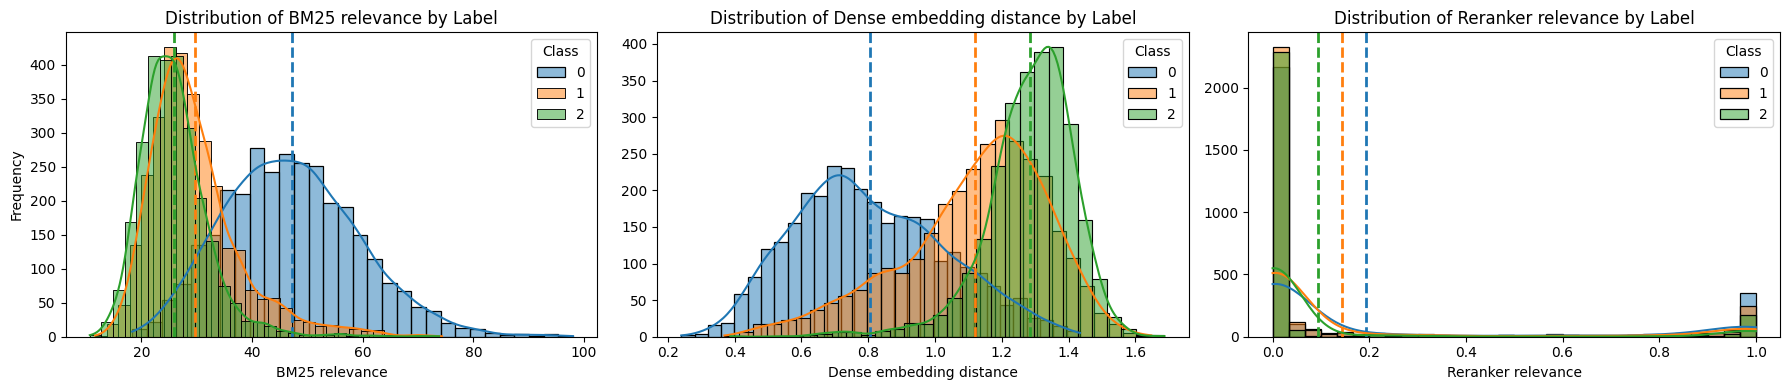

In [36]:
def multiplot_feature_distribution_by_label(df, features, feature_names, label_col='label', averages=None):
    n_features = len(features)
    fig, axs = plt.subplots(1, n_features, figsize=(6 * n_features, 4))
    if n_features == 1:
        axs = [axs]
    cmap = plt.get_cmap('tab10')
    labels = sorted(df[label_col].unique())
    for i, feature in enumerate(features):
        ax = axs[i]
        for j, label in enumerate(labels):
            subset = df[df[label_col] == label]
            color = cmap(j % 10)
            sns.histplot(subset[feature], kde=True, bins=30, label=f'{label}', alpha=0.5, ax=ax, color=color)
            # Draw vertical line for average
            if averages is not None:
                avg = averages.loc[feature_names[i], f'Label {label}']
                ax.axvline(avg, color=color, linestyle='--', linewidth=2)
        ax.set_title(f'Distribution of {feature_names[i]} by Label')
        ax.set_xlabel(feature_names[i])
        if i == 0:
            ax.set_ylabel('Frequency')
        else:
            ax.set_ylabel('')
        leg = ax.legend(title="Class")
    plt.tight_layout()
    plt.show()

multiplot_feature_distribution_by_label(trainset, features, feature_names, label_col='label', averages=averages)

In [320]:
reference_scores = trainset[trainset['label'] == 0]['top_dense_score']

# Initialize lists to store metrics
accuracies = []
precisions = []
recalls = []

alphas = [0.3, 0.2, 0.1, 0.05]

# Iterate over alphas and compute metrics
for alpha in alphas:
    testset = apply_z_test_to_dataframe(testset, reference_series=reference_scores, column='top_dense_score', alpha=alpha)
    accuracy = accuracy_score(testset['in_scope_pred'], testset['answerable'])
    precision = precision_score(testset['in_scope_pred'], testset['answerable'], average='weighted')
    recall = recall_score(testset['in_scope_pred'], testset['answerable'], average='weighted')
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Alpha': alphas,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls
})

# Display the table
if True:
    print(results_df)
else:
    print(results_df.to_latex(index=False, float_format="%.4f"))

   Alpha  Accuracy  Precision    Recall
0   0.30  0.843137   0.846131  0.843137
1   0.20  0.843137   0.842268  0.843137
2   0.10  0.823529   0.839784  0.823529
3   0.05  0.754902   0.829232  0.754902


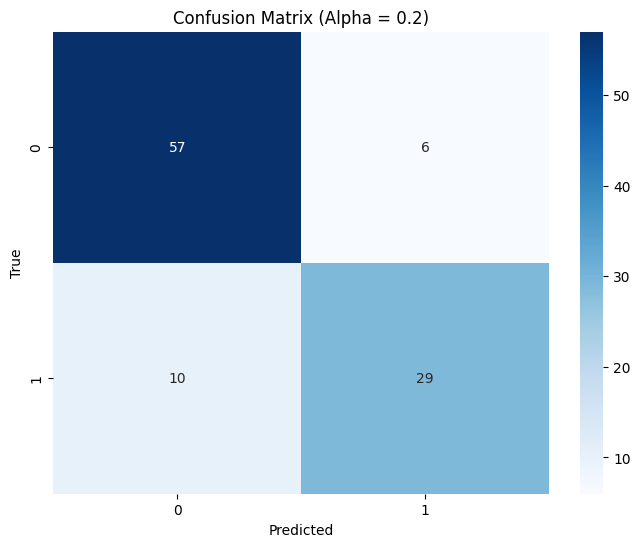

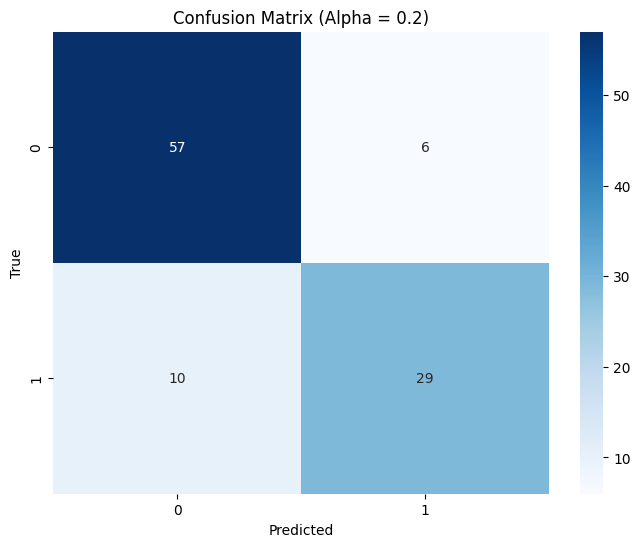

In [329]:
# conf matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)
    plt.show()

# Plot confusion matrix for the best alpha
best_alpha = 0.2
best_testset = apply_z_test_to_dataframe(testset, reference_series=reference_scores, column='top_dense_score', alpha=best_alpha)
plot_confusion_matrix(best_testset['in_scope_pred'], best_testset['answerable'],
                        labels=[0, 1], title=f'Confusion Matrix (Alpha = {best_alpha})')
plot_confusion_matrix(best_testset['in_scope_pred'], best_testset['answerable'],
                        labels=[0, 1], title=f'Confusion Matrix (Alpha = {best_alpha})')

In [18]:
alpha = 0.2

trainset = apply_z_test_to_dataframe(trainset, reference_series=reference_scores, column='top_dense_score', alpha=alpha)
testset = apply_z_test_to_dataframe(testset, reference_series=reference_scores, column='top_dense_score', alpha=alpha)

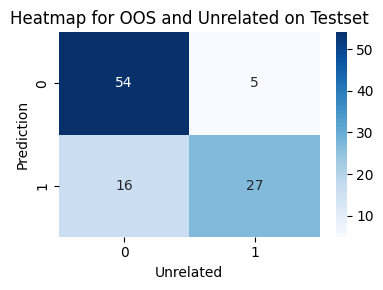

In [20]:
# Create a pivot table for the heatmap
heatmap_data = testset.pivot_table(index='OOS', columns='unrelated', aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Heatmap for OOS and Unrelated on Testset")
plt.xlabel('Unrelated')
plt.ylabel('Prediction')
plt.tight_layout()
plt.show()

In [44]:
# set RAG models
rag = {
        "model": RAG(reranker_name="flashrank", retrieve_top_k=10),
        "name": "topk10"
    }

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Loading default flashrank model for language en
Default Model: ms-marco-MiniLM-L-12-v2
Loading FlashRankRanker model ms-marco-MiniLM-L-12-v2 (this message can be suppressed by setting verbose=0)
Loading model FlashRank model ms-marco-MiniLM-L-12-v2...
Error loading model: Run 'None' not found
Error loading scope model: Run 'None' not found


In [74]:
# configure training
models = [
        {
            "model": LogisticRegression(
                multi_class='ovr',
                solver='lbfgs',
                random_state=1
            ),
            "name": "logreg_ovr"
        },
        {
            "model": LogisticRegression(
                multi_class='multinomial',
                solver='lbfgs',
                random_state=1
            ),
            "name": "logreg_softmax"
        },
        {
            "model": DecisionTreeClassifier(
                random_state=1,
                max_depth=5
            ),
            "name": "decision_tree"
        }
    ]

features = [
    {
        'list': ['top_sparse_score'],
        'name': 'f1'
    },
    {
        'list': ['top_dense_score'],
        'name': 'f2'
    },
    {
        'list': ['top_sparse_score', 'top_dense_score'],
        'name': 'f3'
    },
    {
        'list': ['top_sparse_score', 'top_dense_score', 'top_reranker_score'],
        'name': 'f4'
    }
]

# select single configuration
if True:
    models = [models[0]]
    features = [features[2]]

label = 'label'

In [41]:
def train_model(df, features, label, model):
    X = df[features].values
    y = df[label].values
    model.fit(X, y)
    return model

def log_constructor_params(instance, cls):
    sig = inspect.signature(cls.__init__)
    bound_args = sig.bind_partial()
    bound_args.apply_defaults()
    all_params = bound_args.arguments

    # Exclude 'self'
    all_params = {k: v for k, v in all_params.items() if k != 'self'}

    # Now get the actual values from the instance if they've changed
    for param in all_params:
        try:
            value = getattr(instance, param)
        except AttributeError:
            value = all_params[param]
        mlflow.log_param(param, str(value))

In [78]:
## log all to mlflow
## only use one config for features

# set mlflow experiment
mlflow.set_experiment("eval_scope_models")

features = features[0]['list']
  
for model in models:
    modelname = model['name']
    run_name = f"{rag['name']}_{modelname}"
    with mlflow.start_run(run_name=run_name) as run:

        # train model
        model = train_model(trainset, features=features, label=label, model=model['model'])

        # predict on testset
        testset['logreg_prediction'] = model.predict(testset[features].values) 
        testset['logreg_probability'] = model.predict_proba(testset[features].values)[:, 1]

        # get metrics
        retrieve_accuracy = 999
        if 'top_reranker_doc' in testset.columns:
            retrieve_accuracy = accuracy_score(testset['doc_id'], testset['top_reranker_doc'])
        accuracy = accuracy_score(testset[label], testset['logreg_prediction'])
        f1 = f1_score(testset[label], testset['logreg_prediction'], average='weighted')
        precision = precision_score(testset[label], testset['logreg_prediction'], average='weighted')
        recall = recall_score(testset[label], testset['logreg_prediction'], average='weighted')

        # quadratic weighted kappa
        kappa = cohen_kappa_score(testset[label], testset['logreg_prediction'], weights='quadratic')

        # log to mlflow
        log_constructor_params(rag['model'], rag['model'].__class__)
        mlflow.log_param("rag_name", rag["name"])
        mlflow.log_param("model_name", modelname)
        mlflow.log_param("features", str(features))
        mlflow.log_param("trainset_size", len(trainset))
        mlflow.log_param("testset_size", len(testset))
        mlflow.log_param("n_labels", len(testset[label].unique()))
        mlflow.log_param("label", label)
        mlflow.log_param("database", os.getenv("embedding_path", ""))

        mlflow.sklearn.log_model(model, artifact_path="model")

        mlflow.log_metric("retrieve_accuracy", retrieve_accuracy)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score_weighted", f1)
        mlflow.log_metric("precision_weighted", precision)
        mlflow.log_metric("recall_weighted", recall)
        mlflow.log_metric("kappa", kappa)

c:\Users\SjoerdO\AppData\Local\pypoetry\Cache\virtualenvs\rag--7y4UdRY-py3.13\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
2025/06/27 09:22:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [46]:
# Create a DataFrame to store kappa metric values for each combination of model and feature
results = []

for model_dict in models:
    model_name = model_dict['name']
    for feat in features:
        # Train model
        trained_model = train_model(trainset, features=feat['list'], label=label, model=model_dict['model'])
        # Predict on testset
        preds = trained_model.predict(testset[feat['list']].values)
        # Compute quadratic weighted kappa
        kappa_val = cohen_kappa_score(testset[label], preds, weights='quadratic')
        results.append({
            'model': model_name,
            'features': feat['name'],
            'kappa': kappa_val
        })

kappa_df = pd.DataFrame(results)
print(kappa_df)


c:\Users\SjoerdO\AppData\Local\pypoetry\Cache\virtualenvs\rag--7y4UdRY-py3.13\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\SjoerdO\AppData\Local\pypoetry\Cache\virtualenvs\rag--7y4UdRY-py3.13\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\SjoerdO\AppData\Local\pypoetry\Cache\virtualenvs\rag--7y4UdRY-py3.13\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its defa

             model features     kappa
0       logreg_ovr       f1  0.633043
1       logreg_ovr       f2  0.739831
2       logreg_ovr       f3  0.783217
3       logreg_ovr       f4  0.791922
4   logreg_softmax       f1  0.642028
5   logreg_softmax       f2  0.747988
6   logreg_softmax       f3  0.744086
7   logreg_softmax       f4  0.758917
8    decision_tree       f1  0.600000
9    decision_tree       f2  0.737150
10   decision_tree       f3  0.768017
11   decision_tree       f4  0.756817


c:\Users\SjoerdO\AppData\Local\pypoetry\Cache\virtualenvs\rag--7y4UdRY-py3.13\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\SjoerdO\AppData\Local\pypoetry\Cache\virtualenvs\rag--7y4UdRY-py3.13\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


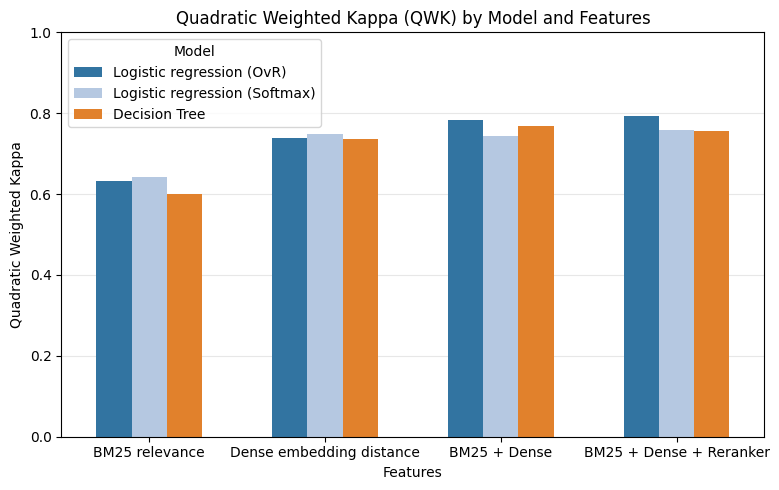

In [106]:
plt.figure(figsize=(8, 5))
palette = plt.get_cmap('tab20')
legend_labels = ['Logistic regression (OvR)', 'Logistic regression (Softmax)', 'Decision Tree']
feature_labels = ['BM25 relevance', 'Dense embedding distance', 'BM25 + Dense', 'BM25 + Dense + Reranker']

ax = sns.barplot(data=kappa_df, x='features', y='kappa', hue='model', palette=palette.colors, width=0.6)
plt.title('Quadratic Weighted Kappa (QWK) by Model and Features')
plt.xlabel('Features')
plt.ylabel('Quadratic Weighted Kappa')
plt.xticks(ticks=range(len(feature_labels)), labels=feature_labels, rotation=0)

# Fix legend labels
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles, legend_labels, title='Model', loc='upper left')

ax.grid(axis='y', alpha=0.3, zorder=0)
ax.set_axisbelow(True)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()


In [64]:
kappa_df

,model,features,kappa
0,logreg_ovr,f1,0.633043
1,logreg_ovr,f2,0.739831
2,logreg_ovr,f3,0.783217
3,logreg_ovr,f4,0.791922
4,logreg_softmax,f1,0.642028
5,logreg_softmax,f2,0.747988
6,logreg_softmax,f3,0.744086
7,logreg_softmax,f4,0.758917
8,decision_tree,f1,0.600000
9,decision_tree,f2,0.737150


In [186]:
testset['final_prediction'] = 0
testset.loc[testset['logreg_prediction'] == 0, 'final_prediction'] = 1 # unanswerable
testset.loc[testset['OOS'] == 1, 'final_prediction'] = 2 # unrelated

In [107]:
# drop unused columns
fusion_labels = set(col for col in testset.columns if col.endswith("fusion_label"))
testset = testset.drop(fusion_labels, axis=1)
testset.head(3)

,doc_id,q_id,question,answer,category,unrelated,answerable,label,top_sparse_score,top_dense_score,top_reranker_doc,top_reranker_score,logreg_prediction,logreg_probability
0,tech_142,tech_142_0_2,How do the interactions between colliding gala...,"When galaxies collide with one another, their ...",tech,0,1,0,51.693789,0.810495,tech_142,0.997508,0,0.147337
1,business_175,business_175_0_4,How does BigBasket's strategy align with curre...,BigBasket's strategy aligns with current marke...,business,0,0,1,23.164027,1.075090,business_50,0.009202,1,0.579936
2,politics_59,politics_59_0_1,What was the primary focus of the House Accoun...,The primary focus of the House Accountability ...,politics,0,0,1,36.931634,1.273418,politics_58,0.000384,2,0.333324


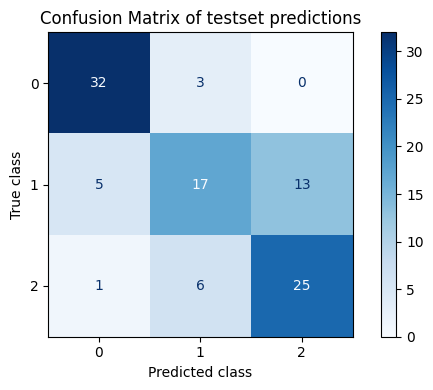

In [108]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extract the true labels and predictions
y_true = testset['label']
y_pred = testset['logreg_prediction']

# Get the unique class labels (in case they're not 0, 1, 2...)
classes = np.unique(np.concatenate([y_true, y_pred]))

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with proper labels
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', ax=ax)

ax.set_title('Confusion Matrix of testset predictions')
ax.set_xlabel('Predicted class')
ax.set_ylabel('True class')
plt.tight_layout()
plt.show()


In [116]:
# Calculate binary accuracy: predicting if class 0 or not
y_true_binary = (testset['label'] == 0).astype(int)
y_pred_binary = (testset['logreg_prediction'] == 0).astype(int)
binary_accuracy = accuracy_score(y_true_binary, y_pred_binary)
binary_accuracy

0.9117647058823529

In [100]:
cmap = plt.get_cmap('tab10')
class_colors = [cmap(0), cmap(1), cmap(2)]

label_to_color = {
    0: class_colors[0],
    1: class_colors[1],
    2: class_colors[2]
}

c:\Users\SjoerdO\AppData\Local\pypoetry\Cache\virtualenvs\rag--7y4UdRY-py3.13\Lib\site-packages\matplotlib\collections.py:1121: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


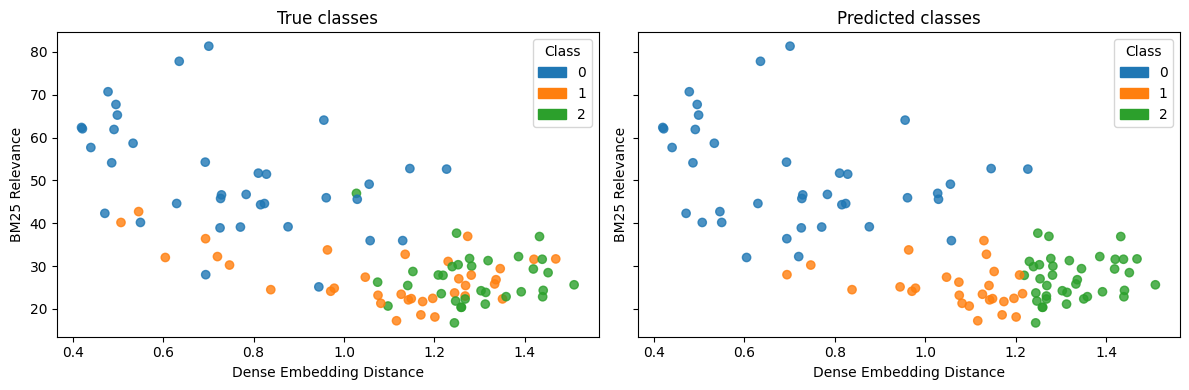

In [114]:
# Map colors based on labels
true_colors = testset['label'].map(label_to_color)
pred_colors = testset['logreg_prediction'].map(label_to_color)

# Scatter plot dense against sparse similarity with label as color
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Plot 1: True classes
scatter1 = axs[0].scatter(
    testset['top_dense_score'],
    testset['top_sparse_score'],
    alpha=0.8,
    color=true_colors
)
axs[0].set_title('True classes')
axs[0].set_xlabel('Dense Embedding Distance')
axs[0].set_ylabel('BM25 Relevance')
axs[0].legend(*scatter1.legend_elements(), title="Class")

# Plot 2: Predicted classes
scatter2 = axs[1].scatter(
    testset['top_dense_score'],
    testset['top_sparse_score'],
    alpha=0.8,
    color=pred_colors
)
axs[1].set_title('Predicted classes')
axs[1].set_xlabel('Dense Embedding Distance')
axs[1].set_ylabel('BM25 Relevance')

# Manual legend
legend_elements = [
    mpatches.Patch(color=class_colors[i], label=f'{i}')
    for i in range(len(class_colors))
]
axs[0].legend(handles=legend_elements, title="Class")
axs[1].legend(handles=legend_elements, title="Class")

plt.tight_layout()
plt.show()


In [256]:
(testset[testset['label'] == 0]['top_dense_score'].mean(),
testset[testset['label'] == 1]['top_dense_score'].mean(),
testset[testset['label'] == 2]['top_dense_score'].mean())

(np.float32(0.7438403), np.float32(1.0555464), np.float32(1.196993))

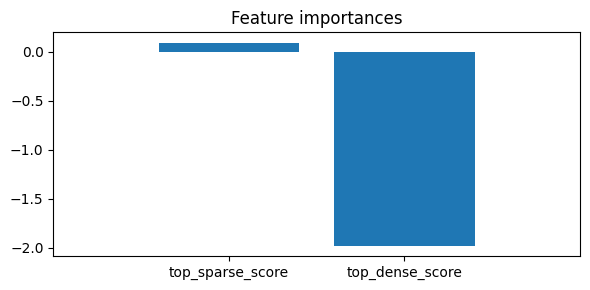

In [232]:
# feature importance
importances = model.feature_importances_ if hasattr(model, 'feature_importances_') else model.coef_[0]
indices = np.argsort(importances)[::-1]
feature_names = features
plt.figure(figsize=(6, 3))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=0)
plt.xlim([-1, len(importances)])
plt.tight_layout()

In [233]:
# Get the coefficients from the trained model
coefficients = model.coef_[0]

# Combine into a DataFrame for readability
feature_importance = pd.DataFrame({
    'feature': features,
    'coefficient': coefficients
}).sort_values(by='coefficient', key=abs, ascending=False)

print(feature_importance)

            feature  coefficient
1   top_dense_score    -1.982764
0  top_sparse_score     0.093102


In [119]:
testset[(testset['label'] == 1) & (testset['logreg_prediction'] == 2)].head(1)

,doc_id,q_id,question,answer,category,unrelated,answerable,label,top_sparse_score,top_dense_score,top_reranker_doc,top_reranker_score,logreg_prediction,logreg_probability
2,politics_59,politics_59_0_1,What was the primary focus of the House Accoun...,The primary focus of the House Accountability ...,politics,0,0,1,36.931634,1.273418,politics_58,0.000384,2,0.333324


In [126]:
chunk_name = 'politics_58'
print([chunk for chunk in rag['model'].embedder.chunkdata if chunk['filename'] == chunk_name][0]['text'])

Republican Sex Scandal Week continues as a new court filing details events related to the ongoing sex trafficking allegations surrounding Florida Rep. Matt Gaetz. The late-Thursday night federal filing references sealed eyewitness statements that describe a high school junior attending a party in a home laden with drugs, where Gaetz and other adults came together for sex. As NOTUS reports, Gaetz has consistently claimed he was not at the July 2017 party, but testimony from his own ex-girlfriend rebuts that claim. The witnesses cite the presence of “alcohol, cocaine, ecstasy … and marijuana” and confirm that those present were there to “engage in sexual activities.” They also confirm the presence of a 17-year-old girl who was “naked” at the party. The event took place at the home of lobbyist Chris Dorworth, a friend of Gaetz. Cell phone records show that Gaetz and Dorworth communicated “constantly” during the day before the party—including some 30 text messages. RELATED STORY: '2 guys, 

## Eval counterfactual

In [136]:
rag = RAG(LLM_name='mistral-small-latest')

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Loading default flashrank model for language en
Default Model: ms-marco-MiniLM-L-12-v2
Loading FlashRankRanker model ms-marco-MiniLM-L-12-v2 (this message can be suppressed by setting verbose=0)
Loading model FlashRank model ms-marco-MiniLM-L-12-v2...
Error loading model: Run 'None' not found
Error loading scope model: Run 'None' not found


In [205]:
refine_LLM = 'gpt'

def refine_query(query):
    chunks = rag.retrieve(query)
    counterfactual_prompt = rag._format_prompt(query, chunks, prompt="counterfactual")
    counterfactual_response = rag.query_LLM(counterfactual_prompt)
    return counterfactual_response

if refine_LLM == 'mistral':
    rag = RAG(LLM_name='mistral-small-latest')
    refine_col = 'refined_query_mistral'
elif refine_LLM == 'gpt':
    rag = RAG(LLM_name='gpt-4o-mini')
    refine_col = 'refined_query_gpt'

if refine_col not in testset.columns:
    testset[refine_col] = np.nan

mask = testset['label'] == 1

for idx, row in testset[mask].iterrows():
    if pd.notna(testset.at[idx, refine_col]):
        continue  # already processed
    try:
        testset.at[idx, refine_col] = refine_query(row['question'])
    except Exception as e:
        print(f"Error at index {idx}: {e}")
        break

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Loading default flashrank model for language en
Default Model: ms-marco-MiniLM-L-12-v2
Loading FlashRankRanker model ms-marco-MiniLM-L-12-v2 (this message can be suppressed by setting verbose=0)
Loading model FlashRank model ms-marco-MiniLM-L-12-v2...
Error loading model: Run 'None' not found
Error loading scope model: Run 'None' not found


Batches: 100%|██████████| 1/1 [00:00<00:00, 23.51it/s]
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.439745 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.787462 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Error at index 16: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-4gJtKuw2xbUierZw1DByDhtg on tokens per min (TPM): Limit 100000, Used 100000, Requested 1230. Please try again in 8h51m21.6s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


In [150]:
# save testset with refined queries
testset.to_csv("eval_data/ScopeQA/ELOQ_testset_refined.csv", index=False)

In [153]:
embedder = Embedder(model_name="all-MiniLM-L6-v2")

def similarity_scores(rag, df, query_col, refine_LLM):
    "add scores for the closest chunk to each question"
    # check if column already exists
    df[f'sparse_score_{refine_LLM}'] = df[query_col].apply(lambda q: rag.embedder.search_bm25(q, top_k=1)[0][0])
    df[f'dense_score_{refine_LLM}'] = df[query_col].apply(lambda q: rag.embedder.search(q, top_k=1)[0][0][0])

df_ref = testset[mask].copy()

similarity_scores(rag, df_ref, query_col=refine_col, refine_LLM=refine_LLM)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Batches: 100%|██████████| 1/1 [00:00<00:00, 83.71it/s]


In [156]:
df_ref.head(1)

,doc_id,q_id,question,answer,category,unrelated,answerable,label,top_sparse_score,top_dense_score,top_reranker_doc,top_reranker_score,logreg_prediction,logreg_probability,refined_query,refined_query_mistral,refined_query_gpt,sparse_score_mistral,dense_score_mistral
1,business_175,business_175_0_4,How does BigBasket's strategy align with curre...,BigBasket's strategy aligns with current marke...,business,0,0,1,23.164027,1.07509,business_50,0.009202,1,0.579936,<NA>,What are the key trends shaping the B2B sales ...,NaN,71.696788,0.434662


In [157]:
rag_predict = RAG(scope_model_id='48faddebdf6d42eb9ee22a5a0cb46479')

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Loading default flashrank model for language en
Default Model: ms-marco-MiniLM-L-12-v2
Loading FlashRankRanker model ms-marco-MiniLM-L-12-v2 (this message can be suppressed by setting verbose=0)
Loading model FlashRank model ms-marco-MiniLM-L-12-v2...
Successfully loaded model from run 48faddebdf6d42eb9ee22a5a0cb46479
Loaded features: ['top_sparse_score', 'top_dense_score']


In [207]:
len(df_ref)

35

In [165]:
df_ref['mistral_predict'] = df_ref['refined_query_mistral'].apply(lambda q: rag_predict.predict_scope(chunks=rag_predict.retrieve(q), query=q)[0])


Batches: 100%|██████████| 1/1 [00:00<00:00, 62.69it/s]


In [209]:
df_ref['logreg_prediction'].value_counts()

logreg_prediction
1    17
2    13
0     5
Name: count, dtype: int64

In [208]:
df_ref['mistral_predict'].value_counts()

mistral_predict
0    34
1     1
Name: count, dtype: int64

In [311]:
i = 18
print(df_ref['question'].iloc[i])
print(df_ref['logreg_prediction'].iloc[i])
print(df_ref['refined_query_mistral'].iloc[i])
print(df_ref['mistral_predict'].iloc[i])
print('-------------')
print([chunk for chunk in rag.embedder.chunkdata if chunk['filename'] == df_ref['top_reranker_doc'].iloc[i]][0]['text'])

What legal arguments did Dr. Charlotte Proudman present to challenge the disciplinary proceedings against her?
1
What legal arguments did Carly Gregg's defense team present during her trial?
0
-------------
Firing Line‘s Margaret Hoover‘s interview with Bill O’Reilly came to an abrupt end when the PBS host’s line of questioning turned to the allegations of sexual harassment against him. According to Mediaite, the sit-down — which was pre-taped on Tuesday for Friday’s Firing Line — became contentious when Hoover grilled the former Fox News star about the alleged $32 million that was paid out to women who accused him of sexual harassment during his tenure at the conservative news network. (O’Reilly was fired from Fox News in 2017 after The New York Times went public with the settlements.) Author @BillOReilly discusses his new book, the presidency, and the state of conservative media. But what does he say when @MargaretHoover questions him about sexual harassment settlements at @FoxNews? 

In [224]:
i = 20
print(df_ref['question'].iloc[i])
print(df_ref['logreg_prediction'].iloc[i])
print(df_ref['refined_query_mistral'].iloc[i])
print(df_ref['mistral_predict'].iloc[i])
print('-------------')
print([chunk for chunk in rag.embedder.chunkdata if chunk['filename'] == df_ref['top_reranker_doc'].iloc[i]][0]['text'])

What items were seized by police during the operation at the illegal casino in Fresno?
2
What items were seized by Brazilian authorities during the raid on the illegal gold mining dredge in the Amazon rainforest?
0
-------------
The helicopter swooped into one of the most inaccessible corners of the Amazon rainforest. Brazilian special forces commandos leaped from its metal skids into the caiman-inhabited waters below. Their target, lurking in the woodland along Brazil’s Bóia River, was a hulking steel mining dredge, caught red-handed as it drilled into the riverbed, pulverising it in search of gold. Onboard, troops from the national environmental agency, Ibama, and the federal highway police found tools typical of this illegal industry: three bottles of mercury, 10g of gold and an enormous drill bit used to pulp the riverbed below. But a more modern contraption also caught their eye: a sleek white receiver made by Elon Musk’s satellite internet firm Starlink, which is at the centre of

In [ ]:
print([chunk for chunk in rag.embedder.chunkdata if chunk['filename'] == df_ref['top_reranker_doc'].iloc[i]][0]['text'])

In [199]:
print([chunk for chunk in rag.embedder.chunkdata if chunk['filename'] == 'tech_10'][0]['text'])

Google’s cheapest Pixel 9 offers almost everything that makes its top-flight sibling one of the best smaller phones available, cutting a few key ingredients to price match Apple and Samsung. The Guardian’s journalism is independent. We will earn a commission if you buy something through an affiliate link. Learn more. The Pixel 9 costs £799 (€899/$799/A$1,349) shaving £200 off the asking price of the stellar Pixel 9 Pro while sitting above the excellent value sub-£500 Pixel 8a from May. That pits the new Pixel directly against Apple’s new iPhone 16 and Samsung’s Galaxy S24. The Pixel 9 is identical in size and shape to the 9 Pro with matt aluminium sides and glass front and back. It has the same bold camera design on the back and a similar good-looking 6.3in OLED screen on the front. The display is not quite as sharp or bright as the 9 Pro, but the difference is minor. Inside it has the same Tensor G4 chip with at least 128GB of storage, but less RAM with only 12GB not the 16GB of its m

In [198]:
print([chunk for chunk in rag.embedder.chunkdata if chunk['filename'] == 'tech_73'][0]['text'])

IndexError: list index out of range